# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

### Import packages and ModelClass

In [61]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

from HAHModel import HAHModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data for equivalence scale and life cycle income profile

In [62]:
wd = '/Users/Christian/Dropbox/KU - Polit/KA/Thesis'
data = pd.read_excel(
    io=wd+'/equiscale.xlsx',
    sheet_name='output')

# interpolate income profile and slice
data['chi'] = data['chi'].interpolate(method='linear')
data = data.iloc[3:-1,:]

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float')

## Baseline model

In [69]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'zeta':10,
        'chi':chi,
        #'n':n,
        'do_print':True
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve(do_assert=True)
#model_baseline.save()

 t = 3 solved in 33.5 secs
 t = 2 solved in 69.4 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 59.1 secs
 total stay-time  = 10.3 secs
 total ref-time   = 15.1 secs
 total buy-time   = 13.5 secs
 total rent-time   = 4.9 secs
 full model solved in = 102.8 secs
model simulated in 59.2 secs
numba precompiled in 166.1 secs
 last period bequest computed in 8.9 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 9.0 secs
 v_bar and q computed in 1.8 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.9 secs
 v_bar and q computed in 2.5 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 2.7 secs
 v_bar and q computed

In [70]:
model_baseline.simulate()

model simulated in 2.5 secs


### Life Cycle Behaviour in Partial Equilibrium

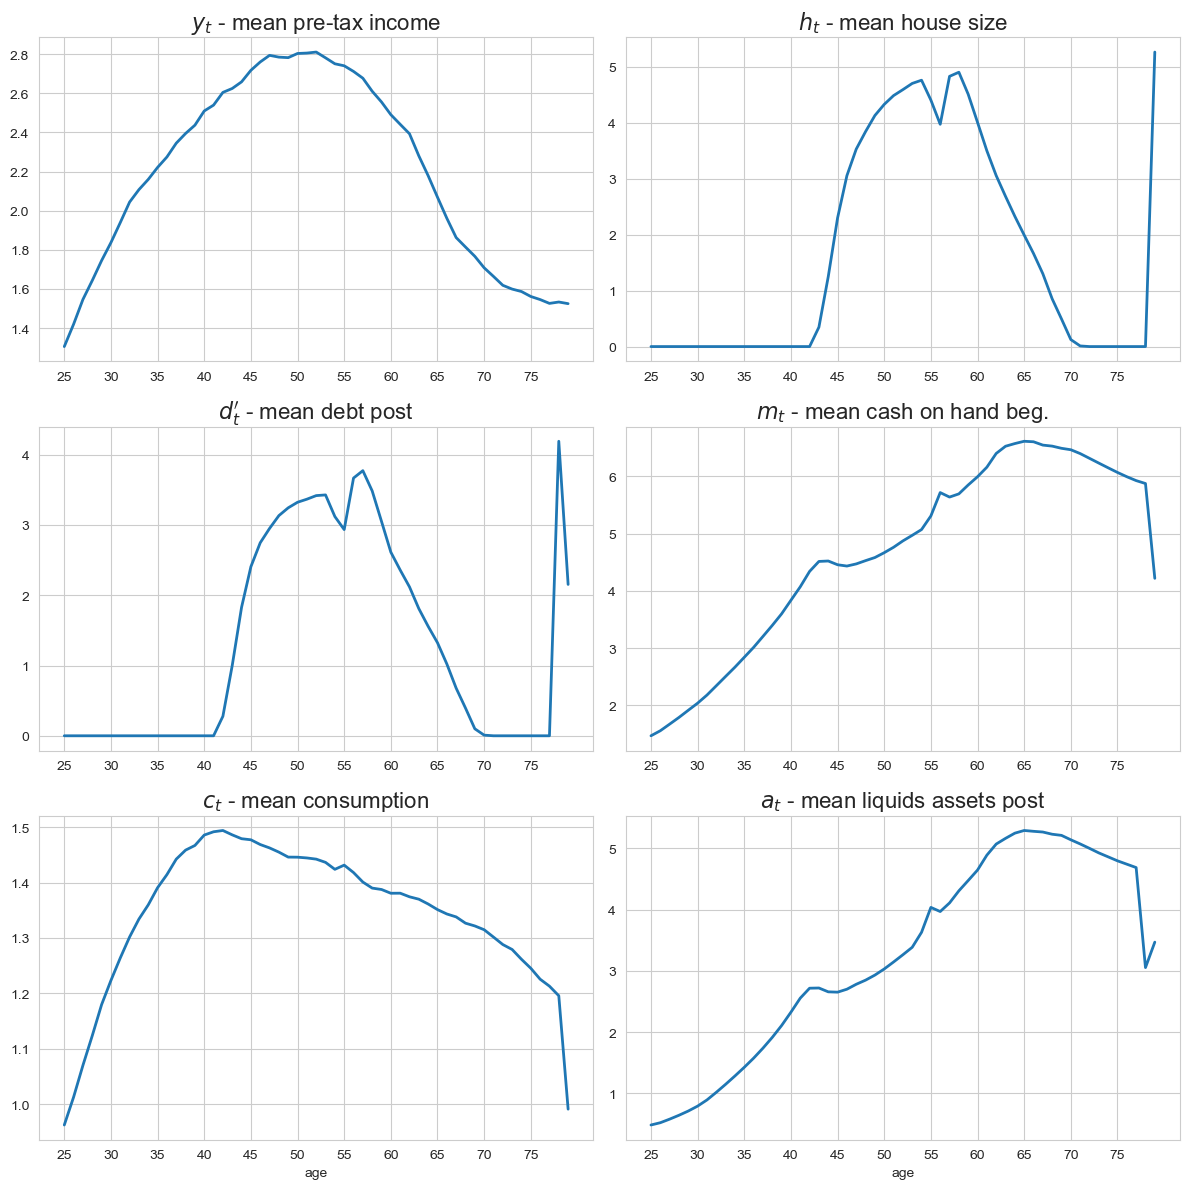

In [91]:
import figs

# average behaviour over the life cycle
figs.lifecycle(model_baseline)

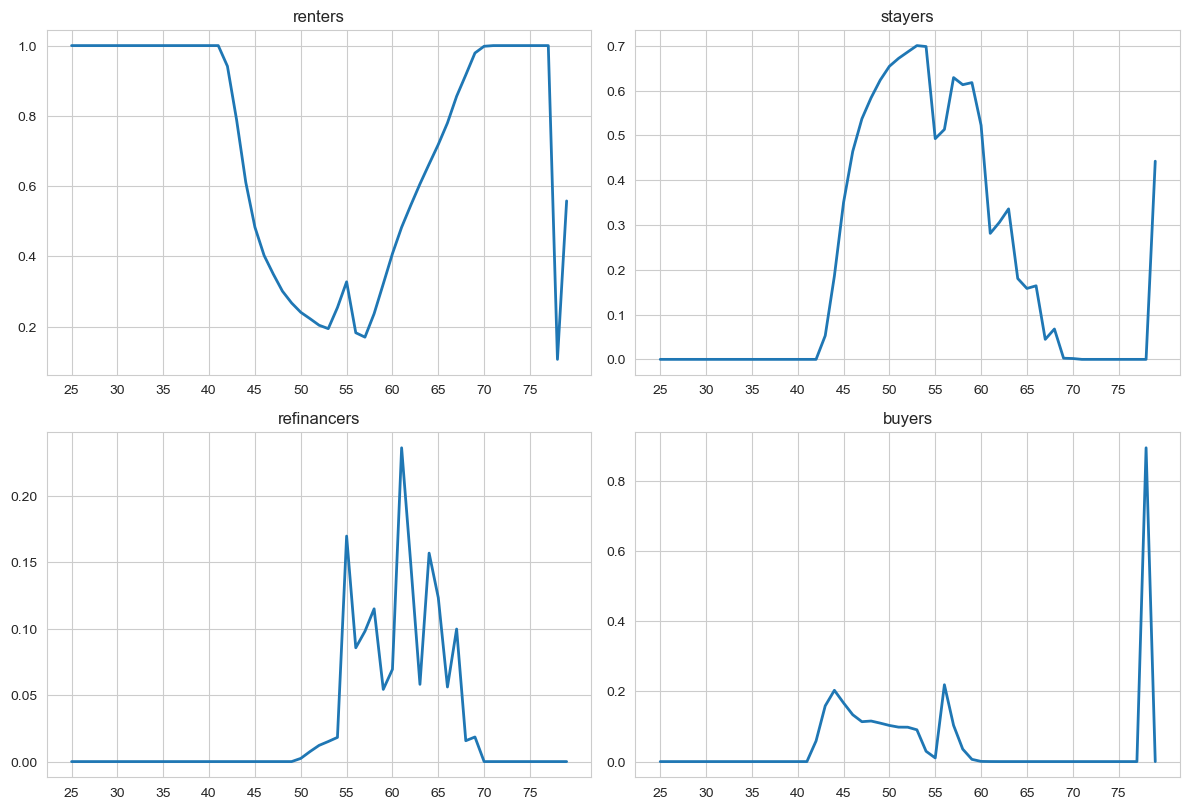

In [72]:
figs.homeownership(model_baseline)

In [76]:

import trans

# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# b. allocate containers and compute shares
own_share = np.zeros(par.T)
stay_share = np.zeros(par.T)
ref_share = np.zeros(par.T)
buy_share = np.zeros(par.T)
rent_share = np.zeros(par.T)


for t in range(par.T):
    stay_share[t] = np.sum(sim.discrete[t]==0)/par.simN
    ref_share[t] = np.sum(sim.discrete[t]==1)/par.simN
    buy_share[t] = np.sum(sim.discrete[t]==2)/par.simN
    rent_share[t] = np.sum(sim.discrete[t]==3)/par.simN

# which year is the crazy buy year?
#for t in range(par.T):
#    print(f'{t+par.Tmin} rent share: {rent_share[t]} stay share: {stay_share[t]} ref share {ref_share[t]} buy share: {buy_share[t]}')

aggregate housing demand is 912681.2999999997


In [89]:
# agggregate housing demand 
H_d = np.sum(sim.h)
print(f'aggregate housing demand is {H_d:.4f}')

# mean bequest
import trans
from EconModel import jit
with jit(model_baseline) as model:
    par = model.par
    ab_tot = 0
    t = par.T-1
    for n in range(par.simN):
        ab_tot += trans.ab_plus_func.py_func(
            sim.a[t,n],
            sim.d_prime[t,n],
            sim.Tda_prime[t,n],
            sim.h_prime[t,n],
            par)
    ab_mean = ab_tot/par.simN
print(f'initial wealth is {np.sum(sim.a0):.4f}')
print(f'total bequest is {ab_tot:.4f}')
print(f'mean bequest is {ab_mean:.4f}')

aggregate housing demand is 912681.3000
initial wealth is 1645.4529
total bequest is 37314.7661
mean bequest is 3.7315


### Test solving the household problem for a few periods

In [ ]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')


In [ ]:
## check NaNs in relevant part of sol.inv_v_bar
#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

########################################################################################################
#
## check for NaNs in relevant part of inv_v_bar
#nan_mat_inv_v_bar = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of sol.inv_v_bar at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_inv_v_bar.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_inv_v_bar}')
#
## check zero or negative entries in relevant part of sol.q
#zero_mat_inv_v_bar = np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of sol.inv_v_bar at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_inv_v_bar.shape[0]} zero or negative entries')
#print(f'the zero indices are {zero_mat_inv_v_bar}')

#######################################################################################################
#
## check for NaNs in relevant part of c_stay
#nan_mat_c_stay = np.argwhere(np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,1:-1]))
#print(f'size of sol.c_stay at t={t} is {sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_c_stay.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_c_stay}')

## check for zeros in relevant part of c_stay
#zero_mat_c_stay = np.argwhere(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] == 0)
#print(f'size of sol.c_stay at t={t} is {sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_c_stay.shape[0]} zero entries')
#print(f'the indices are {zero_mat_c_stay}')

### Sanity checks